In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("SparkSession") \
     .getOrCreate()

sc = spark.sparkContext 
sc

<SparkContext master=yarn appName=SparkSession>

In [2]:
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import DateType
import pyspark.sql.functions as func

In [3]:
schema = StructType([
    StructField("stream_ID", StringType(), True),
    StructField("current_views", StringType(), True),
    StructField("stream_created_time", DateType(), True),
    StructField("game_name", StringType(), True),
    StructField("broadcaster_ID", StringType(), True),
    StructField("broadcaster_name", StringType(), True),
    StructField("delay_setting", StringType(), True),
    StructField("follower_number", StringType(), True),
    StructField("partner_status", StringType(), True),
    StructField("broadcaster_language", StringType(), True),
    StructField("total_views_of_this_broadcaster", StringType(), True),
    StructField("language", StringType(), True),
    StructField("broadcasters_created_time", StringType(), True),
    StructField("playback_bitrate", StringType(), True),
    StructField("source_resolution", StringType(), True),
])

In [4]:
twitch = spark.read.csv('s3://502-project/Twitch_data',sep = "\t", schema=schema)
twitch.show(10)

+-----------+-------------+-------------------+--------------------+--------------+-------------------+-------------+---------------+--------------+--------------------+-------------------------------+--------+-------------------------+----------------+-----------------+
|  stream_ID|current_views|stream_created_time|           game_name|broadcaster_ID|   broadcaster_name|delay_setting|follower_number|partner_status|broadcaster_language|total_views_of_this_broadcaster|language|broadcasters_created_time|playback_bitrate|source_resolution|
+-----------+-------------+-------------------+--------------------+--------------+-------------------+-------------+---------------+--------------+--------------------+-------------------------------+--------+-------------------------+----------------+-----------------+
|13143376000|       206403|         2015-02-14|   League of Legends|      36029255|          riotgames|           -1|        1375163|          True|                  en|               

In [5]:
#remove unnecessary columns
twitch = twitch.drop("broadcasters_created_time").drop("stream_ID").drop("delay_setting").drop("playback_bitrate").drop("source_resolution")
twitch = twitch.drop("broadcaster_name").drop("partner_status")

In [6]:
twitch.createOrReplaceTempView("twitch")
twitch = spark.sql("select current_views, game_name, broadcaster_ID, follower_number, broadcaster_language, total_views_of_this_broadcaster, language, to_date(stream_created_time) as Date from twitch")
twitch.printSchema()
twitch.show()

root
 |-- current_views: string (nullable = true)
 |-- game_name: string (nullable = true)
 |-- broadcaster_ID: string (nullable = true)
 |-- follower_number: string (nullable = true)
 |-- broadcaster_language: string (nullable = true)
 |-- total_views_of_this_broadcaster: string (nullable = true)
 |-- language: string (nullable = true)
 |-- Date: date (nullable = true)

+-------------+--------------------+--------------+---------------+--------------------+-------------------------------+--------+----------+
|current_views|           game_name|broadcaster_ID|follower_number|broadcaster_language|total_views_of_this_broadcaster|language|      Date|
+-------------+--------------------+--------------+---------------+--------------------+-------------------------------+--------+----------+
|       206403|   League of Legends|      36029255|        1375163|                  en|                      636705939|      en|2015-02-14|
|        78525|Counter-Strike: G...|      31239503|         23

In [7]:
twitch_games=spark.sql("SELECT DISTINCT game_name FROM twitch")
twitch_games.show()

+--------------------+
|           game_name|
+--------------------+
|              Dota 2|
|The Elder Scrolls...|
|       Ice cold beer|
|Legacy of Kain: S...|
|  Legend of Grimrock|
|                RIFT|
|          Videogames|
|Divinity Original...|
| H1Z1, 7 days to die|
|Call of Duty: Bla...|
|lets go for that ...|
|Pokémon Ruby/Sapp...|
|            Warcraft|
|           Lets Play|
|Super Street Figh...|
|              Flower|
|         Орден: 1886|
|   Bioshock Infinite|
|            My Life.|
|The Legend of Zel...|
+--------------------+
only showing top 20 rows



# Find the top 20 games with most broadcasters: 

In [8]:
game_broadcaster=spark.sql("SELECT game_name, count(Broadcaster_ID) AS BroadcastNum FROM twitch GROUP BY game_name ORDER BY BroadcastNum DESC")

In [9]:
game_broadcaster.show(10)

+--------------------+------------+
|           game_name|BroadcastNum|
+--------------------+------------+
|   League of Legends|     6254903|
|Counter-Strike: G...|     2534811|
|                  -1|     2247275|
|           Minecraft|     2238612|
|         Dying Light|     2219019|
|             Destiny|     1968721|
|World of Warcraft...|     1868790|
|Call of Duty: Adv...|     1592966|
|             FIFA 15|     1560420|
|  Grand Theft Auto V|     1558320|
+--------------------+------------+
only showing top 10 rows



In [10]:
game_broadcaster.printSchema()

root
 |-- game_name: string (nullable = true)
 |-- BroadcastNum: long (nullable = false)



In [11]:
from pyspark.sql.types import IntegerType

In [12]:
game_broadcaster = game_broadcaster.withColumn("BroadcastNum", game_broadcaster["BroadcastNum"].cast(IntegerType()))

In [13]:
game_broadcaster.printSchema()

root
 |-- game_name: string (nullable = true)
 |-- BroadcastNum: integer (nullable = false)



In [14]:
%matplotlib inline
import seaborn as sns

In [15]:
game_broadcaster_pandas=game_broadcaster.toPandas()

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


In [16]:
game_broadcaster_pandas.head()

,game_name,BroadcastNum
0,League of Legends,6254903
1,Counter-Strike: Global Offensive,2534811
2,-1,2247275
3,Minecraft,2238612
4,Dying Light,2219019


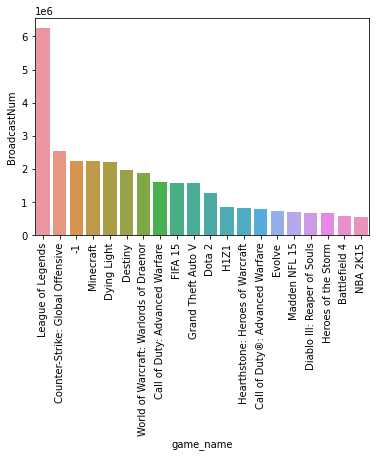

In [17]:
ax=sns.barplot(x='game_name',y='BroadcastNum', data=game_broadcaster_pandas[0:20])
b=ax.set_xticklabels(game_broadcaster_pandas[0:20]['game_name'],rotation=90)

# Find the top 25 games with most followers: 

In [18]:
twitch = twitch.withColumn("follower_number", twitch["follower_number"].cast(IntegerType()))
twitch.createOrReplaceTempView("twitch")

In [19]:
game_follower=spark.sql("SELECT game_name, sum(follower_number) AS FollowerNum FROM twitch GROUP BY game_name ORDER BY FollowerNum DESC")

In [20]:
game_follower.show(10)

+--------------------+-----------+
|           game_name|FollowerNum|
+--------------------+-----------+
|   League of Legends|15903724617|
|Counter-Strike: G...| 7996278926|
|           Minecraft| 5306900412|
|                H1Z1| 4180455092|
|World of Warcraft...| 3808657268|
|Hearthstone: Hero...| 3708075488|
|              Dota 2| 2884217949|
|Call of Duty: Adv...| 1880388181|
|             Destiny| 1852686614|
|         Dying Light| 1759005899|
+--------------------+-----------+
only showing top 10 rows



In [21]:
game_follower_pandas=game_follower.toPandas()

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


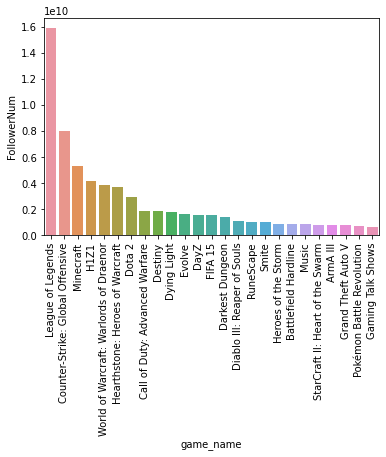

In [22]:
ax=sns.barplot(x='game_name',y='FollowerNum', data=game_follower_pandas[0:25])
b=ax.set_xticklabels(game_follower_pandas[0:25]['game_name'],rotation=90)

# Find the top 25 games with most total views: 

In [23]:
twitch = twitch.withColumn("total_views_of_this_broadcaster", twitch["total_views_of_this_broadcaster"].cast(IntegerType()))
twitch.createOrReplaceTempView("twitch")

In [24]:
game_view=spark.sql("SELECT game_name, sum(total_views_of_this_broadcaster) AS TotalViewNum FROM twitch GROUP BY game_name ORDER BY TotalViewNum DESC")

In [25]:
game_view.show(10)

+--------------------+-------------+
|           game_name| TotalViewNum|
+--------------------+-------------+
|   League of Legends|2294878899237|
|              Dota 2|1264588909288|
|Counter-Strike: G...| 579284610450|
|World of Warcraft...| 506605678375|
|Hearthstone: Hero...| 452381241829|
|                H1Z1| 369572417429|
|               Smite| 336938279171|
|      World of Tanks| 272322776043|
|StarCraft II: Hea...| 271791997213|
| Heroes of the Storm| 252555788666|
+--------------------+-------------+
only showing top 10 rows



In [26]:
game_view_pandas=game_view.toPandas()

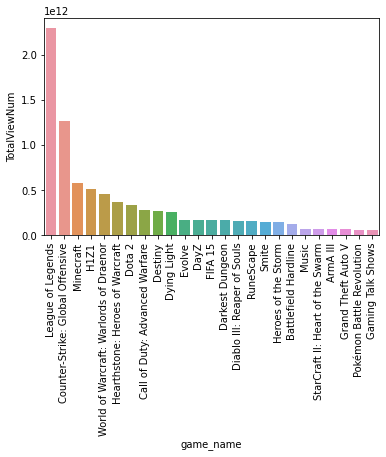

In [27]:
ax=sns.barplot(x='game_name',y='TotalViewNum', data=game_view_pandas[0:25])
b=ax.set_xticklabels(game_follower_pandas[0:25]['game_name'],rotation=90)

# game amazon

In [30]:
amazon_fullgame = spark.read.json("s3://502-project/amazon_game_data")

In [31]:
from pyspark.sql.types import DoubleType
amazon_fullgame = amazon_fullgame.withColumn("overall", amazon_fullgame["overall"].cast(DoubleType()))

In [32]:
amazon_fullgame.createOrReplaceTempView("amazon_fullgame")

In [36]:
game_broadcaster=spark.sql("SELECT asin, count(overall) AS count FROM amazon_fullgame GROUP BY asin ORDER BY count DESC")

In [37]:
from pyspark.sql.types import IntegerType
game_broadcaster = game_broadcaster.withColumn("count", game_broadcaster["count"].cast(IntegerType()))

In [38]:
%matplotlib inline
import seaborn as sns

In [39]:
game_broadcaster_pandas=game_broadcaster.toPandas()

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


In [40]:
game_broadcaster_pandas.head()

,asin,count
0,B00DJFIMW6,16221
1,B00BGA9WK2,7561
2,B00FAX6XQC,5713
3,B009KS4XRO,5489
4,B002VBWIP6,5190


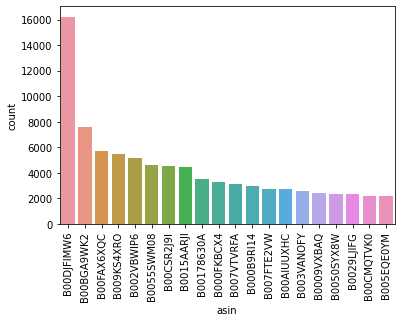

In [41]:
ax=sns.barplot(x='asin',y='count', data=game_broadcaster_pandas[0:20])
b=ax.set_xticklabels(game_broadcaster_pandas[0:20]['asin'],rotation=90)

In [43]:
game_broadcaster_pandas[0:20]['asin']


0     B00DJFIMW6
1     B00BGA9WK2
2     B00FAX6XQC
3     B009KS4XRO
4     B002VBWIP6
5     B0055SWM08
6     B00CSR2J9I
7     B0015AARJI
8     B00178630A
9     B000FKBCX4
10    B007VTVRFA
11    B000B9RI14
12    B007FTE2VW
13    B00AIUUXHC
14    B003VANOFY
15    B0009VXBAQ
16    B0050SYX8W
17    B0029LJIFG
18    B00CMQTVK0
19    B005EQE0YM
Name: asin, dtype: object

In [44]:
game_broadcaster_pandas[0:20]['count']

0     16221
1      7561
2      5713
3      5489
4      5190
5      4638
6      4510
7      4468
8      3522
9      3290
10     3122
11     2996
12     2743
13     2739
14     2572
15     2409
16     2346
17     2309
18     2219
19     2194
Name: count, dtype: int32

# The list of top popular games on Amazon
#### (1) Minion Rush: Despicable Me Official Game 
#### (2)PlayStation 4 500GB Console 
#### (3)DEER HUNTER CLASSIC 
#### (4)BINGO BLITZ: Play Free Bingo games 
#### (5)Xbox Live Gold: 12 Month Membership 
#### (6)Hill Climb Racing
#### (7)PlayStation 3 Dualshock 3 Wireless Controller 
#### (8)Diablo III
#### (9)Spore - PC/Mac
#### (10)SimCity - Standard Edition
#### (11)Xbox 360 LIVE 4000 Points
#### (12)SimCity: Limited Edition
#### (13)Hungry Shark Evolution
#### (14)Logitech Wireless Gaming Headset G930 with 7.1 Surround Sound, Wireless Headphones with Microphone
#### (15)Wii
#### (16)Xbox LIVE 12 Month Gold Membership Card
#### (17)Xbox One with Kinect (Day One Edition)
#### (18)Turtle Beach - Ear Force X12 Amplified Stereo Gaming Headset - Xbox 360 (Discontinued by Manufacturer)